Risk and Return Model, Stock trend prediction

In [22]:
import pandas as pd
import yfinance as yf
from sklearn.linear_model import Ridge
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt


In [23]:
dax = yf.Ticker("^GDAXI")

dax = dax.history(period="max")


In [24]:
 # Create Features that we can provide to the Model

dax["return"] = np.log(dax["Close"] / dax["Close"].shift(1))

# Target 
dax["trend"] = (dax["Close"].shift(-5) > dax["Close"]).astype(int)

dax["ma_fast"] = dax["Close"].rolling(10).mean()
dax["ma_slow"] = dax["Close"].rolling(30).mean()

dax["ma_diff"] = dax["ma_fast"] - dax["ma_slow"]

dax["momentum_10"] = dax["Close"].pct_change(10)

dax["volatility_10"] = dax["return"].rolling(10).std()


features = ["ma_diff", "momentum_10", "volatility_10"]
dax = dax.dropna()

X = dax[features] # what we give to the Model
Y = dax["trend"]  # what we want to predict

split = int(len(dax) * 0.8)

X_train = X.iloc[:split]
X_test  = X.iloc[split:]

y_train = Y.iloc[:split]
y_test  = Y.iloc[split:]

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

preds = model.predict(X_test)
accuracy_score(y_test, preds)

0.5747006767308693

In [25]:
# Risk and Return Model

daily_returns = dax["Close"].pct_change().dropna()

expected_return = daily_returns.mean() * 252
volatility = daily_returns.std() * np.sqrt(252)
sharpe_ratio = expected_return / volatility

print(f"Erwartete Rendite: {expected_return:.2%}")
print(f"Volatilität (Risiko): {volatility:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

Erwartete Rendite: 10.71%
Volatilität (Risiko): 21.65%
Sharpe Ratio: 0.49


In [ ]:
dax["strategy_return"] = 0

dax.loc[X_test.index, "strategy_return"] = (
    preds * dax.loc[X_test.index, "return"]
)

dax["market_return"] = dax["return"]

dax["strategy_cumulative"] = (1 + dax["strategy_return"]).cumprod()
dax["market_cumulative"] = (1 + dax["market_return"]).cumprod()

C:\Users\Henri\AppData\Local\Temp\ipykernel_35244\386724068.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 0.00524456 -0.01540126  0.0060891  ... -0.02089653  0.00939035
  0.01048766]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dax.loc[X_test.index, "strategy_return"] = (


In [27]:
# Nur Test-Periode analysieren
test_strategy = dax.loc[X_test.index, "strategy_return"]
test_market = dax.loc[X_test.index, "market_return"]

# Metriken
def calculate_metrics(returns):
    total_return = (1 + returns).prod() - 1
    volatility = returns.std() * np.sqrt(252)
    sharpe = (returns.mean() * 252) / volatility if volatility > 0 else 0
    max_drawdown = (returns.cumsum() - returns.cumsum().cummax()).min()
    
    return {
        "Total Return": f"{total_return:.2%}",
        "Volatility": f"{volatility:.2%}",
        "Sharpe Ratio": f"{sharpe:.2f}",
        "Max Drawdown": f"{max_drawdown:.2%}"
    }

print("=== STRATEGIE ===")
print(pd.Series(calculate_metrics(test_strategy)))

print("\n=== BUY & HOLD ===")
print(pd.Series(calculate_metrics(test_market)))

=== STRATEGIE ===
Total Return     55.94%
Volatility       18.68%
Sharpe Ratio       0.41
Max Drawdown    -49.07%
dtype: object

=== BUY & HOLD ===
Total Return     71.49%
Volatility       19.25%
Sharpe Ratio       0.46
Max Drawdown    -49.07%
dtype: object


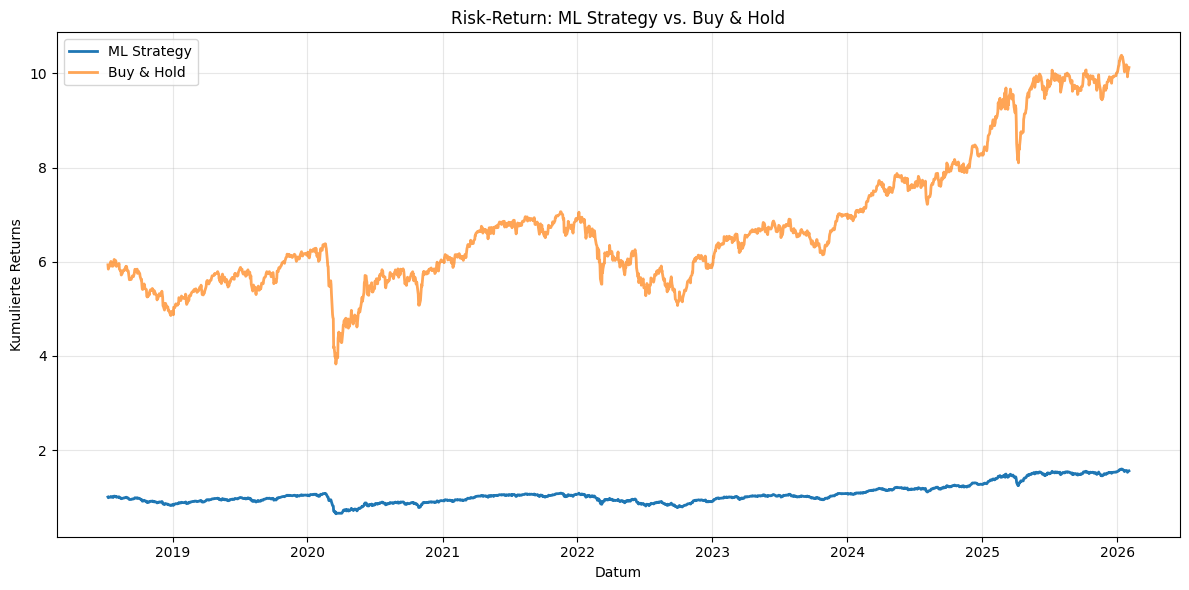

In [28]:
plt.figure(figsize=(12, 6))

# Kumulierte Returns plotten
plt.plot(dax.loc[X_test.index].index, 
         dax.loc[X_test.index, "strategy_cumulative"],
         label="ML Strategy", linewidth=2)

plt.plot(dax.loc[X_test.index].index,
         dax.loc[X_test.index, "market_cumulative"],
         label="Buy & Hold", linewidth=2, alpha=0.7)

plt.title("Risk-Return: ML Strategy vs. Buy & Hold")
plt.xlabel("Datum")
plt.ylabel("Kumulierte Returns")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

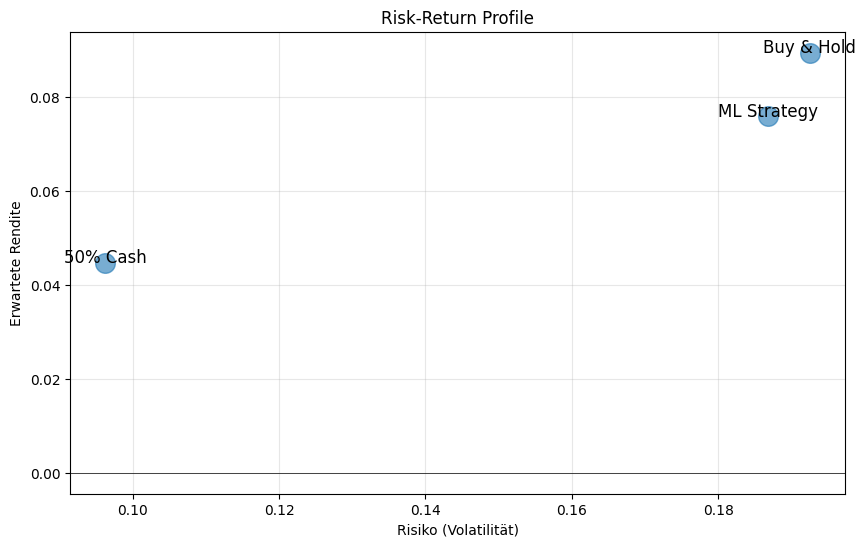

In [ ]:
strategies = {
    "ML Strategy": test_strategy,
    "Buy & Hold": test_market,
    "50% Cash": test_market * 0.5 
}

risk_return_data = []
for name, returns in strategies.items():
    risk_return_data.append({
        "Strategy": name,
        "Return": returns.mean() * 252,
        "Risk": returns.std() * np.sqrt(252)
    })

rr_df = pd.DataFrame(risk_return_data)

plt.figure(figsize=(10, 6))
plt.scatter(rr_df["Risk"], rr_df["Return"], s=200, alpha=0.6)

for i, row in rr_df.iterrows():
    plt.annotate(row["Strategy"], 
                 (row["Risk"], row["Return"]),
                 fontsize=12, ha='center')

plt.xlabel("Risiko (Volatilität)")
plt.ylabel("Erwartete Rendite")
plt.title("Risk-Return Profile")
plt.grid(alpha=0.3)
plt.axhline(0, color='black', linewidth=0.5)
plt.show()